In [62]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

votes_yes_1990 = pd.read_csv("1990_yes_votes.csv")


In [13]:
# Given list of people who voted "yes" for each bill in each year, generate dictionary for each year:
#   params: 
#       * vote_history -- a pandas df with cols "bill_number, display_name, first_name, id, last_name, party, state"
#                         representing yes votes from a particular year
#                         (could be an entry in the dictionary vote_yes)
#   returns:
#       * pairs_from_year -- a dictionary pairs_from_year such that 
#             pairs_from_year[(sen1_id, sen2_id)]= number of times senator1 & senator2 both voted "yes" in given year
#             sen1_id < sen2_id
def gen_pairs_from_vote(vote_history):
    pairs_from_year = {}
    for name, group in vote_history.groupby("bill_number"):
        print('anme', name,group)
        pairs_bill = itertools.combinations(group["id"], 2)
        for pair in list(pairs_bill):
            id1 = min(pair)
            id2 = max(pair)
            if (id1, id2) in pairs_from_year:
                pairs_from_year[(id1, id2)] += 1
            else:
                pairs_from_year[(id1, id2)] = 1
    return pairs_from_year

In [56]:
# given a year and a threshold of votes to exclude, constructs a weighted graph of senator voting behavior
#   params: 
#       year: year to make graph of
#       votes_to_exclude: if a bill has more than threshold votes of yes, we exclude it
#   returns:
#       weighted graph of senate voting behavior      
def create_graph(year, threshold):
    csv = str(year) + '_yes_votes.csv'
    df = pd.read_csv(csv)
    conn = sqlite3.connect(":memory:")
    df.to_sql('votes', conn, if_exists='replace', index=False)
    
    #selects all bills with fewer than votes_to_exclude yes votes
    query = '''
    SELECT * from votes
    where bill_number in
    (
        SELECT bill_number FROM
        (
            SELECT bill_number, count(1) as num_yes
            FROM votes
            GROUP BY 1
        )
        WHERE num_yes <='''+ str(threshold)+'''
    )
    '''
    df_pruned = pd.read_sql_query(query, conn)
    df_pruned.to_sql('votes', conn, if_exists='replace', index=False)
    query = '''
    SELECT e1,e2,count(1)as weight from 
    (
        Select A.display_name as e1, B.display_name as e2 
        FROM votes A 
        JOIN votes B 
        on (A.bill_number = B.bill_number AND A.display_name != B.display_name)
    ) 
        WHERE e1 < e2
        GROUP BY 1,2
    '''
    weighted = pd.read_sql_query(query, conn)
    return nx.from_pandas_dataframe(weighted, 'e1', 'e2', 'weight')
    

In [57]:
#example on how to use create_graph
g1990 = create_graph(1990, 90)
nx.info(g1990)

/Users/tonyzeng/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1165: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


'Name: \nType: Graph\nNumber of nodes: 101\nNumber of edges: 5045\nAverage degree:  99.9010'

In [66]:
betweenness =[]
for i in range(1990, 2013):
    g = create_graph(i,90)
    #some metric of graph centrality that we want to measure

/Users/tonyzeng/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1165: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


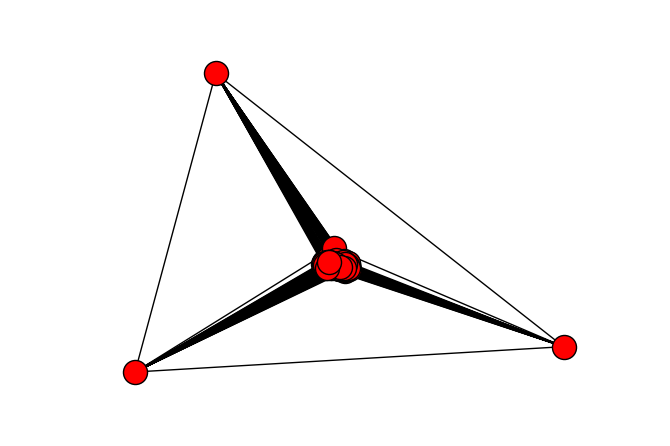

In [48]:
G_weighted = nx.from_pandas_dataframe(weighted, 'e1', 'e2', 'weight')
nx.draw(G_weighted)